In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

sys.path.append("../code/")
# warnings.simplefilter("ignore", UserWarning)

In [3]:
from params import *

from inference.main import k_fold_inf

from data.dataset import InferenceDataset
from data.transforms import HE_preprocess

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")


df = pd.read_csv(OUT_PATH + f"df_images_{256}_{4}.csv")

In [5]:
folds = df["5fold"].unique()

for i, fold in enumerate(folds):
    df_val = df[df["5fold"] == fold].reset_index()
    val_images = df_val["tile_name"].apply(lambda x: x.split("_")[0]).unique()
    print(val_images)

['2f6ecfcdf' 'b2dc8411c' '4ef6695ce']
['8242609fa' '0486052bb' '26dc41664']
['aaa6a05cc' 'e79de561c' 'c68fe75ea']
['cb2d976f4' '095bf7a1f' 'afa5e8098']
['b9a3865fc' '54f2eec69' '1e2425f28']


### Data

In [6]:
root = TIFF_PATH_4
rle_path = DATA_PATH + "train_4.csv"
reduce_factor = 1
rles = pd.read_csv(rle_path)

In [7]:
img = "2f6ecfcdf" # "aaa6a05cc"

In [8]:
dataset = InferenceDataset(
    f"{root}/{img}.tiff",
    rle=rles[rles['id'] == img]["encoding"],
    overlap_factor=2,
    reduce_factor=reduce_factor,
    tile_size=256,
    transforms=HE_preprocess(augment=False, visualize=True),
)

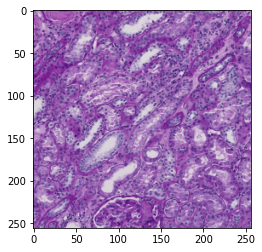

In [9]:
img, pos = dataset[len(dataset) // 3]

plt.imshow(img.numpy().transpose(1, 2, 0))
plt.show()

### Inference

In [10]:
# log_folder = "../logs/2021-03-18/0/"  # b5
# log_folder = "../logs/2021-03-26/3/"  # b5 512
# log_folder = "../logs/2021-03-27/1/"  # seresnext
# log_folder = "../logs/2021-03-28/1/"  # b6

# log_folder = "../logs/2021-03-29/7/"  # b5 + 10 ep
# log_folder = "../logs/2021-03-30/0/"  # b5 + 20 ep

# log_folder = "../logs/2021-03-31/0/"  # b4 512
# log_folder = "../logs/2021-04-01/2/"  # bot unext
# log_folder = "../logs/2021-04-02/3/"  # b6
# log_folder = "../logs/2021-04-04/1/"  # b0
log_folder = "../logs/2021-04-05/4/"  # b1
# log_folder = "../logs/2021-04-06/2/"  # b1 512
# log_folder = "../logs/2021-04-08/2/"  # b1 lovasz
# log_folder = "../logs/2021-04-08/5/"  # b2 fp16
# log_folder = "../logs/2021-04-09/0/"  # b2 fp32 (tbc)
# log_folder = "../logs/2021-04-09/12/"  # ++b1
# log_folder = "../logs/2021-04-10/1/"  # b1 fp16
# log_folder = "../logs/2021-04-10/3/"  # b1 fp32 (repro)
# log_folder = "../logs/2021-04-10/4/"  # b2 fp32

log_folder = "../logs/2021-04-11/3/"  # b1 2 512

In [11]:
class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

config = json.load(open(log_folder + 'config.json', 'r'))
config = Config(**config)

In [12]:
# Fields not defined in old configs :
try:
    _ = config.tile_size
except:
    config.tile_size = 256
    config.reduce_factor = 4
    
try:
    _ = config.use_bot
except:
    config.use_bot = False
    config.use_fpn = False
    
try:
    _ = config.double_model
except:
    config.double_model = False

In [13]:
df = pd.read_csv(OUT_PATH + f"df_images_256_4.csv")

In [14]:
config.overlap_factor = 1.5
use_tta = True
global_threshold = 0.4
config.selected_folds = [0, 1, 2, 3, 4]
save = True

In [15]:
%%time
scores = k_fold_inf(
    config,
    df,
    log_folder=log_folder,
    use_full_size=False,
    global_threshold=global_threshold,
    use_tta=use_tta,
    save=save,
)


-------------   Fold 1 / 5  -------------


 -> Loading weights from ../logs/2021-04-11/3/Unet_efficientnet-b1_0.pt


    -> Validating 

 - Scored 0.9617 for downscaled image 2f6ecfcdf with threshold 0.35
 - Scored 0.9615 for image 2f6ecfcdf with threshold 0.40

 - Scored 0.9602 for downscaled image b2dc8411c with threshold 0.35
 - Scored 0.9596 for image b2dc8411c with threshold 0.40

 - Scored 0.9467 for downscaled image 4ef6695ce with threshold 0.35
 - Scored 0.9469 for image 4ef6695ce with threshold 0.40


-------------   Fold 2 / 5  -------------


 -> Loading weights from ../logs/2021-04-11/3/Unet_efficientnet-b1_1.pt


    -> Validating 

 - Scored 0.9594 for downscaled image 8242609fa with threshold 0.50
 - Scored 0.9583 for image 8242609fa with threshold 0.40

 - Scored 0.9304 for downscaled image 0486052bb with threshold 0.45
 - Scored 0.9308 for image 0486052bb with threshold 0.40

 - Scored 0.9532 for downscaled image 26dc41664 with threshold 0.45
 - Scored 0.9531 for ima

In [20]:
print(f'Local CV score is {np.mean(scores):.4f} for threshold {global_threshold}')   # 1.5

Local CV score is 0.9396 for threshold 0.4


In [16]:
print(f'Local CV score is {np.mean(scores):.4f} for threshold {global_threshold}')   # 1.5

Local CV score is 0.9372 for threshold 0.4
